<center><h1>M1 MMA - Optimisation</h1><h2>TP évalué 21/12/23</h2></center>

<h4>Boîte à outils Python.</h4>
<ul>
    <li>Produit matriciel / scalaire : $\mbox{np.dot()}$</li>
    <li>Transposée d'une matrice $X$ : $\mbox{X.transpose()}$.</li>
</ul>

In [1]:
# importation des librairies
import numpy as np
import matplotlib.pyplot as plt
from time import time
params = {'tex.usetex': True}

<h2>Contexte de l'étude</h2>

On considère donnée une famille de couples $((x_i,y_i))_{0\leq i\leq M-1}$ où pour tout $i$, $x_i$ est un point du plan $\mathbb{R}^2$ et $y_i\in\{-1,1\}$ défini l'appartenance de $x_i$ à une des deux classes représentées par les nombres $-1$ et $1$.

Les couples $(x_i,y_i)$, pour $0\leq i\leq M-1$, forment une réalisation d'un échantillon de taille $M$ de la variable aléatoire $(\tilde X,\tilde Y)$ à valeurs dans $\mathbb{R}^2\times\{-1,1\}$, c'est-à-dire une réalisation de $M$ variables aléatoires indépendantes $(\tilde X_i,\tilde Y_i)$ de même loi que le couple $(\tilde X,\tilde Y)$.

Une réalisation de la variable $(\tilde X,\tilde Y)$ est donnée par la fonction $\mbox{genererCouple}$ suivante :

In [2]:
u = np.random.randn(2)
u = 1/np.linalg.norm(u)*u
def genererCouple():
    # renvoie une réalisation de la variable aléatoire (\tilde X, \tilde Y)
    if np.random.rand() < 0.5:
        x, y = 2.*np.random.randn(2) + 3*u, -1
    else:
        x, y = 2.*np.random.randn(2) - 3*u, 1
    return [x, y]

La cellule suivante génère les données fixées du problème $((x_i,y_i))_{0\leq i\leq M-1}$ et les affiches graphiquement. La population de points $x_i$ de classe "-1" est représentée en vert et celle de type "1" en rouge. Les $x_i$ sont stockés dans un vecteur $\mbox{xi_list}$ et les $y_i$ dans un vecteur $\mbox{yi_list}$.

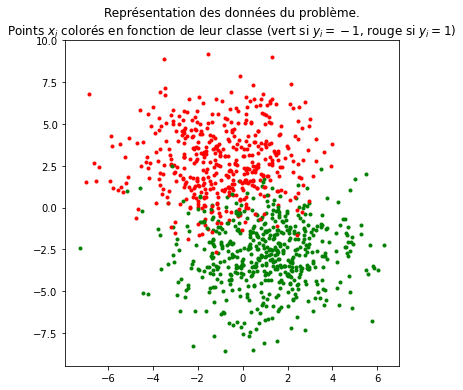

In [3]:
# Génération des données
M = 1000
xi_list, yi_list = np.zeros((M, 2)), np.zeros(M)
for i in range(M):
    xi_list[i, :], yi_list[i] = genererCouple() # on stocke les données ((x_i, y_i))_i

plt.figure(figsize = (6, 6))
for i in range(M):
    if yi_list[i] == 1: # si x_i est de type 1 alors on affiche un point rouge
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "red")
    else: # sinon en vert
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "green")
plt.title(r"Représentation des données du problème." +  u"\n" + r"Points $x_i$ colorés en fonction de leur classe (vert si $y_i=-1$, rouge si $y_i=1$)")
plt.axis("tight")
plt.show()

L'objectif est, à partir de la seule des données d'entraînement ci-dessus i.e. les $((x_i,y_i))_{0\leq i\leq M-1}$, d'apprendre à prédire, sachant une nouvelle réalisation $x\in\mathbb{R}^2$ de $\tilde X$, la valeur de la classe $y$ associée.

Pour cela on va déterminer la meilleure droite passant par $(0,0)$ qui sépare les deux populations (rouge et vert) de points $x_i$.

Une droite qui passe par $(0,0)$ a pour équation $f(x) = 0$ où $f : x\in\mathbb{R}^2 \mapsto a_0 x_0 + a_1 x_1$ avec $a = (a_0, a_1)\in\mathbb{R}^2$ un vecteur normal de la droite. On va donc chercher le meilleur $a$ assurant la séparation. Pour $x$ donné, quand $f(x)>0$, on considèrera que la classe de $x$ est $y = 1$ et quand $f(x) = -1$, on considèrera que la classe de $x$ est $y = -1$.

<h2>Etude théorique et résolution numérique d'un problème d'optimisation</h2>

Pour cela on va chercher à résoudre le problème d'optimisation suivant
$$\min_{a\in\mathbb{R}^2} F(a),$$
où $F : a\in\mathbb{R}^2\mapsto \frac1{2M}\|Xa - Y\|_2^2 + \frac{\lambda}2 \| a\|_2^2$.

Avec
<ul>
    <li>$\lambda > 0$,</li>
    <li>$X\in\mathcal{M}_{M,2}(\mathbb{R})$, où la ligne $i\in\{0,\ldots,M-1\}$ de $X$ est $x_i\in\mathbb{R}^2$,</li>
    <li>$Y = (y_i)_{0\leq i\leq M-1}\in\mathbb{R}^M$.</li>
</ul>

In [4]:
# Implémentation de la matrice X, du vecteur Y, et de la fonction F
X = xi_list
Y = yi_list
lbda = 1
def F(a):
    return 1/(2*M)*np.linalg.norm(np.dot(X, a) - Y)**2 + 1/2*lbda*np.linalg.norm(a)**2

<b>1) Calculer le gradient et la hessienne de $F$.</b>

Soit $a, h\in\mathbb{R}^2$. Alors $F(a+h) = F(a) + \frac1M \langle Xa - Y, Xh\rangle + \lambda \langle a, h\rangle + o_{h\to0}(h) = F(a) + \langle \frac1MX^T(Xa - Y) + \lambda a, h\rangle$. Donc $\nabla F(a) = \frac1MX^T(Xa - Y) + \lambda a$.

Puis $\nabla F(a+h) = \nabla F(a) + \frac1M X^TX h + \lambda h = \nabla F(a) + \left(\frac1MX^TX + \lambda I_2\right) h$, donc $\nabla^2F(a) = \frac1MX^TX + \lambda I_2$.

<b>2) Montrer que $F$ est strictement convexe sur $\mathbb{R}^2$.</b>

La matrice $X^TX$ (de taille $2\times 2$) est symétrique positive puisque pour tout $h\in\mathbb{R}^2$, $h^TX^TXh = \langle Xh, Xh\rangle = \|Xh\|^2\geq 0$. Donc pour tout $a\in\mathbb{R}^2$, $\nabla^2 F(a) \succeq \lambda I_2 \succ 0$. Ainsi $\nabla^2F(a)$ est définie positive. Comme c'est vrai pour tout $a$ dans $\mathbb{R}^2$, $F$ est strictement convexe sur $\mathbb{R}^2$.

<b>3) Montrer que $F$ admet un unique minimum global.</b>

On a pour tout $a\in\mathbb{R}^2$, $F(a) \geq \frac{\lambda}2 \|a\|^2$ donc $F(a) \to+\infty$ quand $\|a\|\to+\infty$. La fonction $F$ est donc coercive. Elle est continue sur $\mathbb{R}^2$ car $\mathcal{C}^\infty$. Donc $F$ admet au moins un minimum global sur $\mathbb{R}^2$. Comme $F$ est strictement convexe, ce minimum global est unique.

Autre méthode : comme pour $a$, $\nabla F(a) = \frac1MX^T(Xa - Y) + \lambda a$, on a $\nabla F(a) = 0$ si et seulement si $a = (\frac1M X^T X + \lambda I_2)^{-1} \left(\frac1M X^T Y\right)$, car la matrice $\frac1M X^T X + \lambda I_2$ est inversible. Donc $F$ admet un unique point fixe, et puisque $F$ est strictement convexe, cet unique point fixe est l'unique minimum global de $F$.

<b>4) Implémenter une fonction $\mbox{gradF}$ prenant en argument $\mbox{a}$ et renvoyant le gradient de $F$ en $a\in\mathbb{R}^2$.</b>

In [5]:
A = 1/M*np.dot(X.transpose(), X)
b = 1/M*np.dot(X.transpose(), Y)
def gradF(a):
    # gradient de F en a
    return np.dot(A, a) - b + lbda*a

In [6]:
# Test de vérification de votre fonction gradF
# Valider cette cellule une fois gradF implémenté

a = np.random.randn(2)
e1, e2 = np.array([1, 0]), np.array([0, 1])
epsilon = 1e-5
df1, df2 = (F(a + epsilon*e1) - F(a - epsilon*e1))/(2*epsilon), (F(a + epsilon*e2) - F(a - epsilon*e2))/(2*epsilon)
print("Calcul et implémentation correcte de gradF si la valeur suivante est inférieure à 10^{-7} :", np.linalg.norm(np.array([df1, df2] - gradF(a))))

Calcul et implémentation correcte de gradF si la valeur suivante est inférieure à 10^{-7} : 1.2859475431446937e-11


<b>5) Implémenter une fonction codant l'algorithme de descente de gradient <u>à pas fixe</u>, c'est-à-dire dont le pas de descente est constant valant $\tau > 0$.

La fonction s'appelera $\mbox{gradient_pas_fixe}$ et prendra en arguments
<ul>
    <li>la fonction $\mbox{gradF}$ renvoyant le gradient de $F$,</li>
    <li>un point $\mbox{a0}$ d'où démarrera la descente,</li>
    <li>$\mbox{tau}$ le pas de descente fixe,</li>
    <li>une tolérance $\mbox{tol}$ utilisée pour la condition d'arrêt de la descente.</li>
</ul>
Elle renverra le dernier itéré et la liste de tous les itérés. 
</b>

In [7]:
def gradient_pas_fixe(gradF, a0, tau, tol):
    a = a0
    a_list = [a0]
    d = -gradF(a)
    while np.linalg.norm(d) > tol:
        a = a + tau * d
        d = -gradF(a)
        a_list.append(a)
    return a, a_list

<b>6) Utiliser la fonction $\mbox{gradient_pas_fixe}$ pour résoudre le problème d'optimisation. Le pas de descente $\mbox{tau}$ sera choisi grâce à l'indication donnée dans la cellule suivante.</b>

In [8]:
# Valider cette case
A = 1/M*np.dot(X.transpose(), X)
b = 1/M*np.dot(X.transpose(), Y)
m = np.min(np.linalg.eig(A + lbda*np.eye(2))[0])
L = np.linalg.norm(A + lbda*np.eye(2))
tau_max = (2*m)/(L**2)
print("Choisissez votre pas de descente fixe \"tau\" inférieur au nombre suivant : ", tau_max)

Choisissez votre pas de descente fixe "tau" inférieur au nombre suivant :  0.0490187779046876


In [9]:
a0 = np.zeros(2)
tau = .9*tau_max
tol = 1e-10
a_star, a_list = gradient_pas_fixe(gradF, a0, tau, tol)
tol = 1e-7
a, a_list = gradient_pas_fixe(gradF, a0, tau, tol)

<b>Vérifier votre solution en validant la case suivante</b>

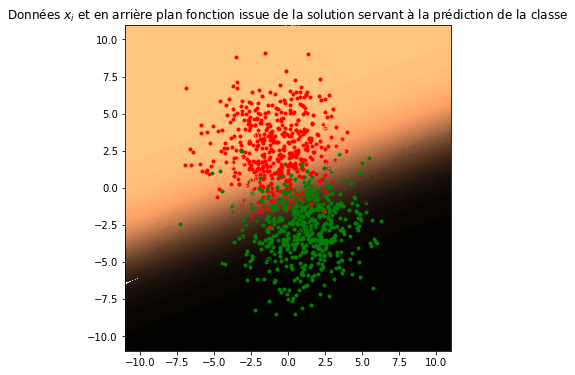

In [10]:
def sigmoid(t):
    return 4/(1 + np.exp(-4*t)) - 1
def prediction(x):
    # fonction servant à prédire la classe de x. Renvoie un nombre entre -1 et 1.
    return sigmoid(np.dot(a_star, x))

# calcul des valeurs de la fonction "prediction" sur une grille
len_grid = 50
X0 = np.linspace(-11, 11, len_grid)
X1 = np.linspace(-11, 11, len_grid)
X0, X1 = np.meshgrid(X0, X1)
Z = np.zeros(X0.shape)
for i in range(len_grid):
    for j in range(len_grid):
        Z[i, j] = prediction(np.array([X0[i, j], X1[i, j]]))

# plot de la fonction "prediction" et des données
fig, ax = plt.subplots(figsize = (6, 6))
CS = ax.contourf(X0, X1, Z, 50, cmap = "copper")
for i in range(M):
    if yi_list[i] == 1:
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "red")
    else:
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "green")
ax.clabel(CS, fontsize = 8)
ax.set_title(r"Données $x_i$ et en arrière plan fonction issue de la solution servant à la prédiction de la classe")
ax.set_aspect("equal", adjustable = "box") # pour que les axes aient la même échelle

<b>7) Illustrer la convergence de l'algorithme en utilisant la fonction $\mbox{plt.semilogy}$. Qu'observez-vous ? Qu'en déduisez-vous pour la convergence de la suite des itérés produite par l'algorithme implémenté ?</b>

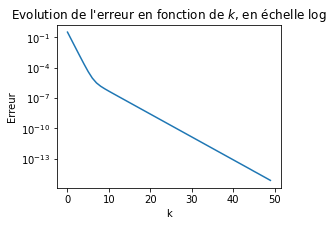

In [11]:
plt.figure(figsize = (4, 3))
plt.semilogy(range(len(a_list)),[abs(F(a) - F(a_star)) for a in a_list])
plt.title(r"Evolution de l'erreur en fonction de $k$, en échelle $\log$")
plt.xlabel("k")
plt.ylabel("Erreur")
plt.show()

On remarque que l'erreur (entre la valeur de la fonction $F$ en l'itéré $a^{(k)}$ et la valeur minimale de la fonction $F$) tend vers $0$ et qu'à partir d'un certain rang le graphe est une droite de pente négative. Comme l'axe des ordonnées est en échelle log, cela signifie que la convergence de la suite $(F(a^{(k)}))$ vers $F(a^*)$ est linéaire.

En effet, pour rappel, puisque on a APCR : $\log(|F(a^{(k)}) - F(a^*)|) = \log(\alpha) k + c$, avec $\log(\alpha) < 0$ la pente de la droite et $s$ l'ordonnée à l'origine. On a donc APCR : $|F(a^{(k)}) - F(a^*)| = C\alpha^k$ avec $\alpha \in ]0,1[$, ce qui correspond bien à la définition de la convergence linéaire de la suite $(F(a^{(k)}))$ vers $F(a^*)$.